# Hierarchical Clustering of Z-Scored Data

This notebook performs hierarchical clustering on z-scored data using Euclidean distance. We use the average linkage method, with Euclidean distances normalized by the maximum observed distance from multiple data permutations. This normalization ensures that a distance of 1.0 represents the maximum dissimilarity observed between rows or columns in any permutation of the data matrix.

## 1. Load Python packages

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.utils import resample
import os
from pathlib import Path

## 2. Load and visualize data

Data loaded from: /Users/patrickdesrosiers/GitHub/consensus-clustering-hyperactivityAD/data/5x-WT-WTSSFO zscore.xlsx
Data shape: (6269, 17)
Column names: Index(['5xFAD+TdTom', '5xFAD+TdTom.1', '5xFAD+TdTom.2', '5xFAD+TdTom.3',
       'WT+SSFO', 'WT+SSFO.1', 'WT+SSFO.2', 'WT+SSFO.3', 'WT+TdTom',
       'WT+TdTom.1', 'WT+TdTom.2', 'WT+TdTom.3', 'WT+TdTom.4',
       'C: ANOVA Significant', 'N: -Log ANOVA p value', 'T: Genes',
       'T: Protein.Ids'],
      dtype='object')


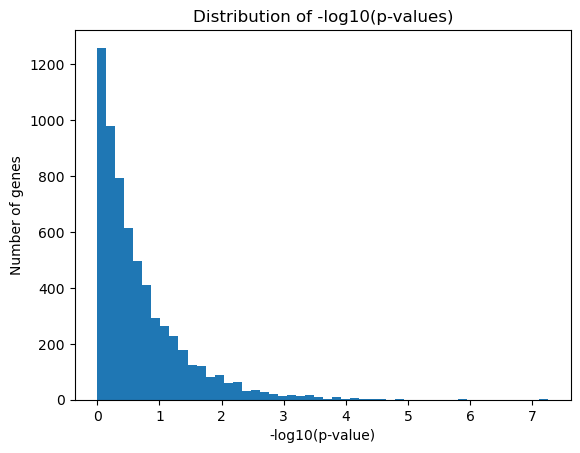

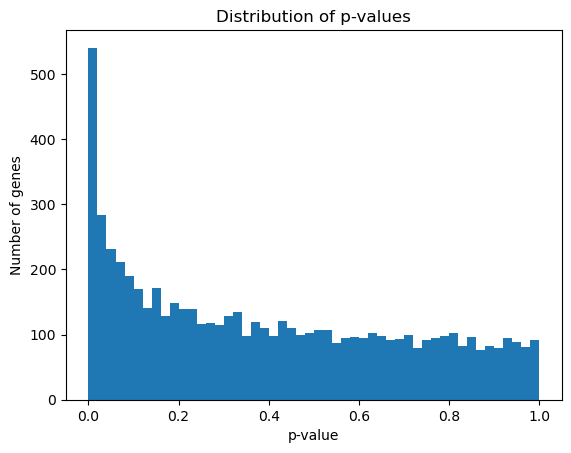

In [2]:
import os
import pandas as pd

# Set path to the local data folder
data_dir = os.path.join(os.getcwd(), 'data')
file_name = '5x-WT-WTSSFO zscore.xlsx'
file_path = os.path.join(data_dir, file_name)

# Load the Excel file
df = pd.read_excel(file_path)

# Display basic info
print("Data loaded from:", file_path)
print("Data shape:", df.shape)
df.head()

# Display the column names
print("Column names:", df.columns)

plt.hist(list(df['N: -Log ANOVA p value']), 50)
plt.xlabel('-log10(p-value)')
plt.ylabel('Number of genes')
plt.title('Distribution of -log10(p-values)')
plt.show()

plt.hist(10**(-np.array(list(df['N: -Log ANOVA p value']))), 50)
plt.xlabel('p-value')
plt.ylabel('Number of genes')
plt.title('Distribution of p-values')
plt.show()


## Feature selection and clustering utilities
This section defines reusable functions to support the analysis pipeline. It includes:
- Selection of top proteins based on ANOVA p-values  
- Computation of distances and dendrograms  
- Noise injection for stability assessment  
- Utilities for plotting labeled dendrograms and performing hierarchical clustering

In [3]:
def select_top_k_genes_by_anova(df, k):
    """
    Select the k genes with the lowest ANOVA p-values from a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing a column 'N: -Log ANOVA p value'.
    k (int): The number of top genes to select (with lowest p-values).

    Returns:
    pd.DataFrame: A DataFrame with the top k genes sorted by increasing p-value.
    """
    # Drop rows with missing ANOVA p-values
    df_valid = df.dropna(subset=['N: -Log ANOVA p value'])

    # Convert -log10(p) to p-value
    df_valid = df_valid.copy()
    df_valid['ANOVA p-value'] = 10 ** (-df_valid['N: -Log ANOVA p value'])

    # Sort by actual p-value (ascending)
    df_sorted = df_valid.sort_values(by='ANOVA p-value')

    # Return top k genes
    return df_sorted.head(k)

def get_max_distance_from_permutations(df, num_permutations=10):
    """
    Compute the maximum Euclidean distance from permuted versions of the dataframe.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    num_permutations (int): Number of permutations to perform. If 0, compute distance using df as is.

    Returns:
    float: The maximum distance observed.
    """
    if num_permutations == 0:
        # Compute distances without permutation
        row_distance = pdist(df.values, metric='euclidean')
        col_distance = pdist(df.T.values, metric='euclidean')
        return max(np.max(row_distance), np.max(col_distance))

    max_distances = []
    for _ in range(num_permutations):
        df_permuted = df.apply(np.random.permutation, axis=0)
        row_distance = pdist(df_permuted.values, metric='euclidean')
        col_distance = pdist(df_permuted.T.values, metric='euclidean')
        max_distances.append(max(np.max(row_distance), np.max(col_distance)))
    return max(max_distances)


# Plot dendrogram with distance labels for columns
def plot_dendrogram_with_labels(linkage_matrix, labels, ax, orientation='top', xlabel_offset=-1.5, ylabel_offset=-0.07):
    """
    Plot a dendrogram with distance labels.

    Parameters:
    linkage_matrix (np.ndarray): The linkage matrix for the dendrogram.
    labels (list): The labels for the dendrogram leaves.
    ax (matplotlib.axes.Axes): The axis to plot the dendrogram on.
    orientation (str): The orientation of the dendrogram ('top', 'bottom', 'left', 'right').
    label_offset (float): The offset for the distance labels.
    """
    dendro = dendrogram(linkage_matrix, labels=labels, ax=ax, orientation=orientation,
                        color_threshold=0, above_threshold_color='grey')
    # Add distance labels slightly above the branches
    for i, d in zip(dendro['icoord'], dendro['dcoord']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        ax.text(x + xlabel_offset, y + ylabel_offset, f'{y:.2f}', va='center', ha='center', color='blue', fontsize=8)
    # Set x-axis labels font size
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)

def perform_clustering(df, method='average'):
    col_distance = pdist(df.T.values, metric='euclidean')
    col_linkage = linkage(col_distance, method=method)
    return col_linkage

# Function to add white noise
def add_white_noise(df, noise_level=0.1):
    noise = np.random.normal(scale=noise_level, size=df.shape)
    df_noisy = df + noise
    return df_noisy

## Consensus Clustering and Rank Analysis of Selected Proteomic Features

This section performs robust clustering of the top ANOVA-selected proteins across experimental groups. 
We use hierarchical clustering with Euclidean distance, bootstrap resampling with white noise perturbation, 
and compute stability diagnostics including stable rank, nuclear rank, and entropy rank to assess cluster structure.


      T: Genes  ANOVA p-value
0          APP   5.544725e-08
3854      Pepd   1.242911e-06
2202    Gpcpd1   1.440357e-05
5161     Smim8   3.043197e-05
6266   mCherry   3.098846e-05
2968    Man2c1   3.538914e-05
3241     Mrtfb   3.919404e-05
5922    Ube2v2   4.426393e-05
134      Adap2   5.962934e-05
638    Bloc1s4   6.196265e-05
6211   Zbtb8os   6.915284e-05
5928     Ube4b   7.257549e-05
38      Abhd12   7.516229e-05
1144    Cox6a1   8.079975e-05
3400     Ncstn   8.397306e-05
3473     Nell2   8.941080e-05
3806     Pdcd6   9.308506e-05
2099      Gfus   1.005055e-04
2670     Kcnq4   1.244945e-04
1008      Clpp   1.278733e-04
6267    mt-Co3   1.292379e-04
5743      Tpm1   1.302027e-04
5205     Sntb2   1.365903e-04
872      Cdh10   1.394954e-04
3030     Mat2b   1.631887e-04
4607       Rp2   1.641005e-04
902      Celf4   1.820204e-04
5820      Tsr2   1.918669e-04
2359    Hectd1   2.263185e-04
3389   Nckap1l   2.289918e-04
472      Ascc2   2.383197e-04
755    Camsap3   2.406080e-04
911      C

<Figure size 1200x1000 with 0 Axes>

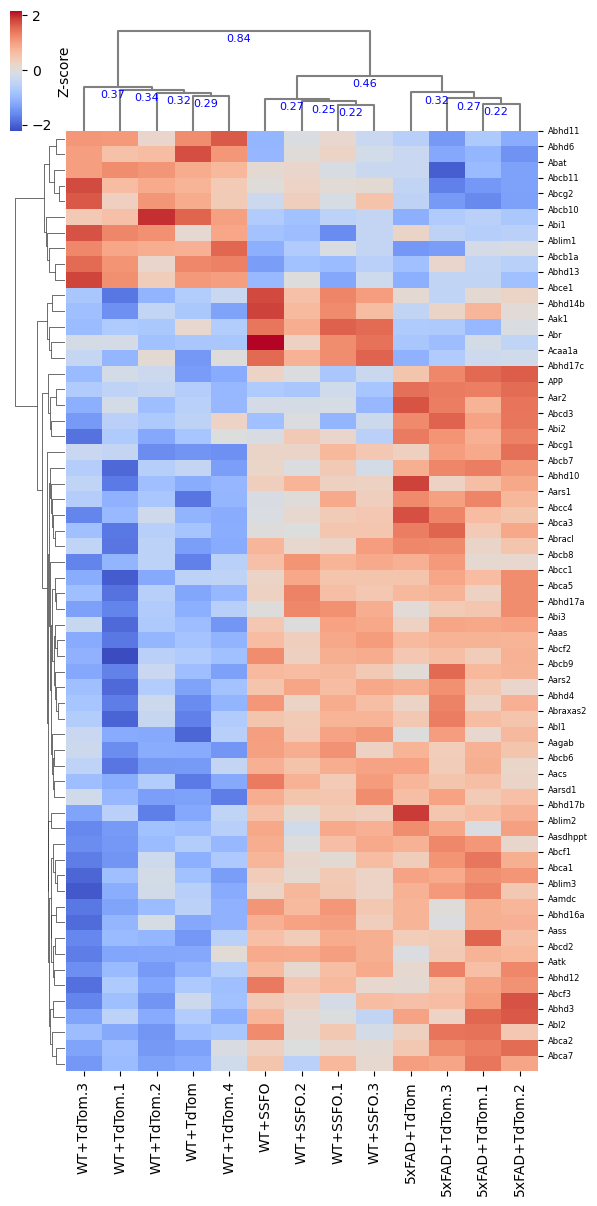

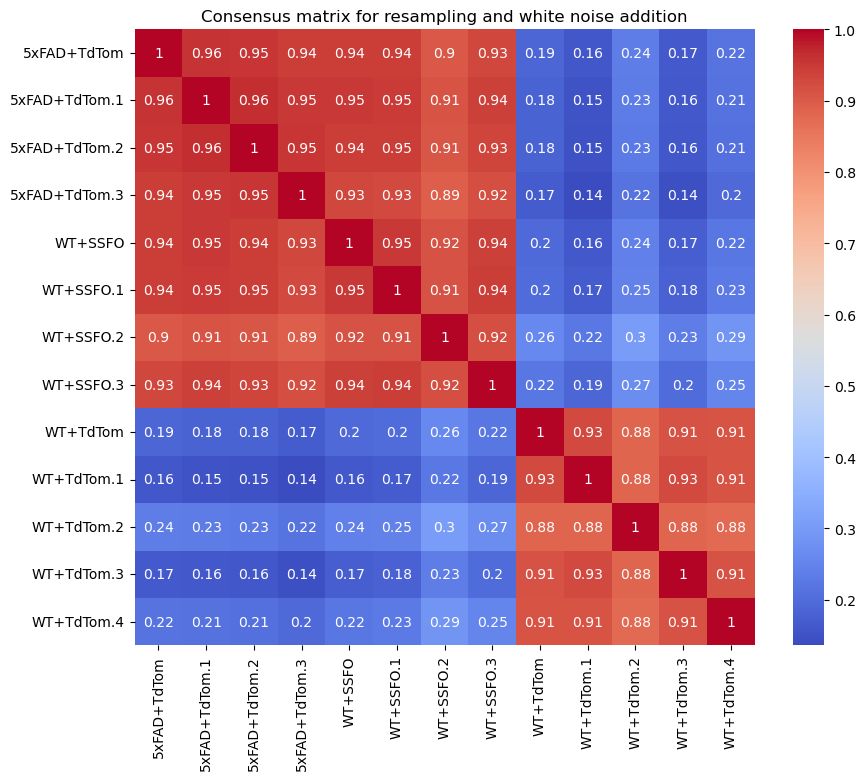

Stable Rank: 1.266641647842001
Nuclear Rank: 1.6181394323988594
Erank: 2.6753365295623466
Rank: 13


In [4]:
# Ensure the results directory exists
results_dir = os.path.join(os.getcwd(), 'results')
os.makedirs(results_dir, exist_ok=True)

# === Feature selection ===
top_genes = select_top_k_genes_by_anova(df, k=60)
print(top_genes[['T: Genes', 'ANOVA p-value']])

# Select specific columns
selected_columns = ['5xFAD+TdTom', '5xFAD+TdTom.1', '5xFAD+TdTom.2', '5xFAD+TdTom.3',
                    'WT+SSFO', 'WT+SSFO.1', 'WT+SSFO.2', 'WT+SSFO.3',
                    'WT+TdTom', 'WT+TdTom.1', 'WT+TdTom.2', 'WT+TdTom.3', 'WT+TdTom.4']

df_zscored = top_genes[selected_columns]
print(df_zscored.shape)
df_zscored.head()

# === Distance computation and linkage ===
num_permutations = 0
max_distance = get_max_distance_from_permutations(df_zscored, num_permutations=num_permutations)

row_distance = pdist(df_zscored.values, metric='euclidean') / max_distance
col_distance = pdist(df_zscored.T.values, metric='euclidean') / max_distance

row_linkage = linkage(row_distance, method='average')
col_linkage = linkage(col_distance, method='average')

# === Clustermap plotting ===
plt.figure(figsize=(12, 10))
clustermap = sns.clustermap(df_zscored, row_cluster=True, col_cluster=True,
                            row_linkage=row_linkage, col_linkage=col_linkage,
                            metric='euclidean', dendrogram_ratio=(.1, .1),
                            cbar_pos=(0.02, 0.90, 0.02, 0.1), cmap='coolwarm', figsize=(6, 12),
                            cbar_kws={'label': 'Z-score'})

plot_dendrogram_with_labels(clustermap.dendrogram_col.linkage,
                            labels=df_zscored.columns,
                            ax=clustermap.ax_col_dendrogram,
                            orientation='top')

# Relabel rows
row_labels = list(df['T: Genes'])
reordered_row_labels = [row_labels[i] for i in clustermap.dendrogram_row.reordered_ind]
clustermap.ax_heatmap.set_yticks(np.arange(len(reordered_row_labels)))
clustermap.ax_heatmap.set_yticklabels(reordered_row_labels, fontsize=6, rotation=0)

# Save clustermap
clustermap_path_base = os.path.join(results_dir, 'clustermap_euclidean_new')
plt.savefig(f"{clustermap_path_base}.png")
plt.savefig(f"{clustermap_path_base}.svg")
plt.savefig(f"{clustermap_path_base}.pdf")
plt.show()

# === Consensus clustering ===
num_bootstraps = 1000
noise_level = 2.0
n_cols = df_zscored.shape[1]
consensus_matrix = np.zeros((n_cols, n_cols))

for _ in range(num_bootstraps):
    df_bootstrap = df_zscored.sample(frac=1, replace=True, axis=0)
    df_noisy = add_white_noise(df_bootstrap, noise_level=noise_level)
    col_linkage = perform_clustering(df_noisy)
    clusters = fcluster(col_linkage, t=2, criterion='maxclust')
    for i in range(n_cols):
        for j in range(n_cols):
            if clusters[i] == clusters[j]:
                consensus_matrix[i, j] += 1

consensus_matrix /= num_bootstraps

# Plot consensus matrix
plt.figure(figsize=(10, 8))
sns.heatmap(consensus_matrix, annot=True, cmap='coolwarm',
            xticklabels=df_zscored.columns, yticklabels=df_zscored.columns)
plt.title('Consensus matrix for resampling and white noise addition')

# Save consensus matrix
consensus_path_base = os.path.join(results_dir, 'consensus_euclidean')
plt.savefig(f"{consensus_path_base}.png")
plt.savefig(f"{consensus_path_base}.svg")
plt.savefig(f"{consensus_path_base}.pdf")
plt.show()

# === Rank diagnostics ===
X = consensus_matrix
singular_values = np.linalg.svd(X, compute_uv=False)

stable_rank = np.sum(singular_values**2) / (singular_values[0]**2)
print("Stable Rank:", stable_rank)

nuclear_norm = np.sum(singular_values)
spectral_norm = singular_values[0]
nuclear_rank = nuclear_norm / spectral_norm
print("Nuclear Rank:", nuclear_rank)

prob = singular_values / np.sum(singular_values)
prob = prob[prob > 1e-12]
erank = np.exp(-np.sum(prob * np.log(prob)))
print("Erank:", erank)

rank = np.sum(singular_values > 1e-12)
print("Rank:", rank)


The script below performs a systematic analysis of gene expression data to evaluate the effect of varying the number of selected genes k on clustering robustness and matrix rank metrics. For a densely sampled range of k values, the script selects the top k genes using ANOVA, computes z-scored expression matrices, and applies hierarchical clustering with Euclidean distances. It then generates cluster heatmaps and computes consensus matrices using resampling with added white noise. Several rank metrics—including stable rank, nuclear rank, entropy-based rank (erank), and numerical rank—are computed from the consensus matrices. All resulting plots and data are saved in the results/threshold_analysis directory.

Processing k=4
Processing k=5
Processing k=6
Processing k=8
Processing k=9
Processing k=11
Processing k=13
Processing k=16
Processing k=19
Processing k=22
Processing k=26
Processing k=32
Processing k=38
Processing k=45
Processing k=53
Processing k=64
Processing k=76
Processing k=90
Processing k=107
Processing k=128
Processing k=152
Processing k=181
Processing k=215
Processing k=256
Processing k=304
Processing k=362
Processing k=430
Processing k=512
Processing k=608
Processing k=724
Processing k=861
Processing k=1024
Processing k=1217
Processing k=1448
Processing k=1722
Processing k=2048
Processing k=2435
Processing k=2896
Processing k=3444
Processing k=4096
Processing k=4870
Processing k=5792


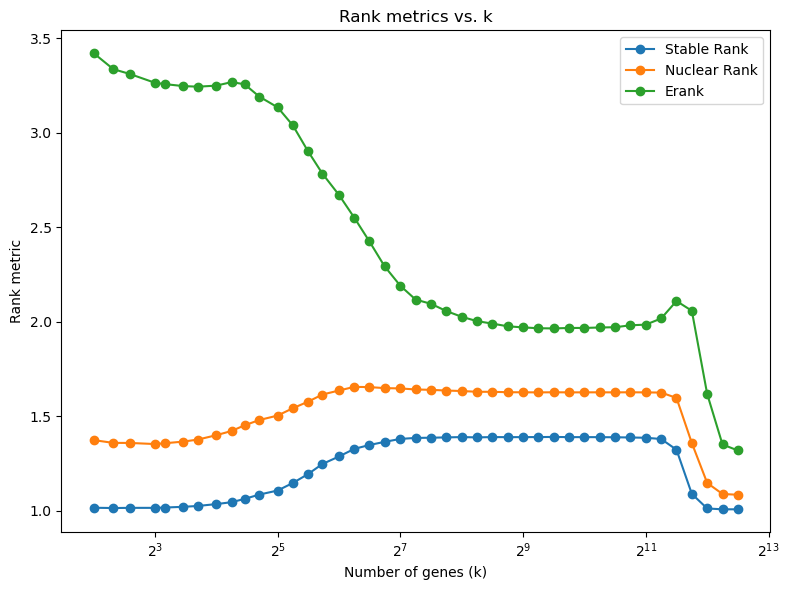

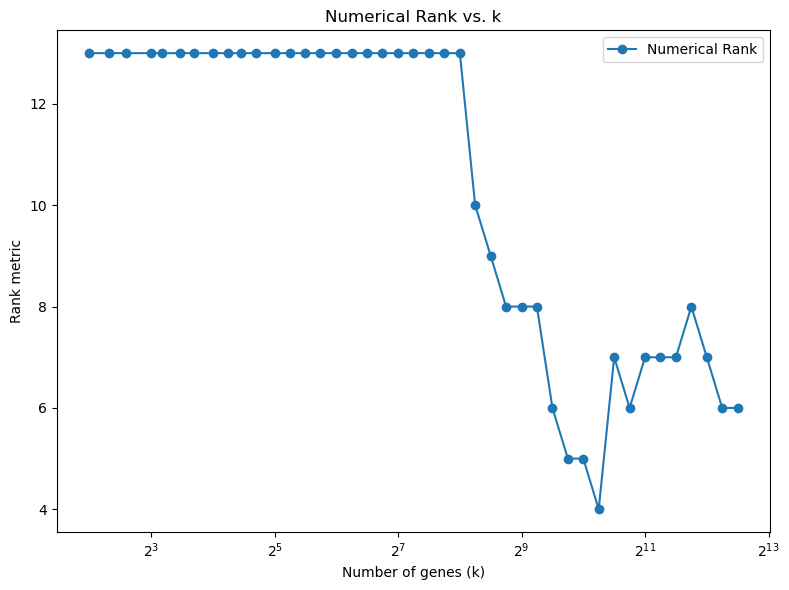

In [5]:
# Define and create the output folder
output_folder = Path("results/threshold_analysis")
output_folder.mkdir(parents=True, exist_ok=True)

# Prepare to record ranks
rank_records = []

# Even more densely sampled k values: 4× original by using 0.25 steps
k_values = [int(2**x) for x in np.arange(2, np.log2(len(df)), 0.25)]
k_values = sorted(set(k_values))  # Remove duplicates and sort

# Select specific columns
selected_columns = ['5xFAD+TdTom', '5xFAD+TdTom.1', '5xFAD+TdTom.2', '5xFAD+TdTom.3',
                    'WT+SSFO', 'WT+SSFO.1', 'WT+SSFO.2', 'WT+SSFO.3', 'WT+TdTom',
                    'WT+TdTom.1', 'WT+TdTom.2', 'WT+TdTom.3', 'WT+TdTom.4']

for k in k_values:
    print(f"Processing k={k}")
    top_genes = select_top_k_genes_by_anova(df, k)
    df_zscored = top_genes[selected_columns]

    # Compute distances
    max_distance = get_max_distance_from_permutations(df_zscored, num_permutations=0)
    row_distance = pdist(df_zscored.values, metric='euclidean') / max_distance
    col_distance = pdist(df_zscored.T.values, metric='euclidean') / max_distance
    row_linkage = linkage(row_distance, method='average')
    col_linkage = linkage(col_distance, method='average')

    # Clustermap
    clustermap = sns.clustermap(df_zscored, row_cluster=True, col_cluster=True,
                                row_linkage=row_linkage, col_linkage=col_linkage,
                                metric='euclidean', cmap='coolwarm', figsize=(6, 12),
                                cbar_kws={'label': 'Z-score'})
    clustermap.fig.suptitle(f'Clustermap for k={k}')
    clustermap_path = output_folder / f'clustermap_k{k}.png'
    clustermap.savefig(clustermap_path)
    plt.close(clustermap.fig)

    # Consensus matrix
    num_bootstraps = 4000
    noise_level = 2.0
    n_cols = df_zscored.shape[1]
    consensus_matrix = np.zeros((n_cols, n_cols))

    for _ in range(num_bootstraps):
        df_bootstrap = df_zscored.sample(frac=1, replace=True, axis=0)
        df_noisy = add_white_noise(df_bootstrap, noise_level=noise_level)
        col_linkage = perform_clustering(df_noisy)
        clusters = fcluster(col_linkage, t=2, criterion='maxclust')
        for i in range(n_cols):
            for j in range(n_cols):
                if clusters[i] == clusters[j]:
                    consensus_matrix[i, j] += 1
    consensus_matrix /= num_bootstraps

    # Plot consensus matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(consensus_matrix, ax=ax, cmap='coolwarm',
                xticklabels=selected_columns, yticklabels=selected_columns)
    ax.set_title(f'Consensus matrix (k={k})')
    consensus_path = output_folder / f'consensus_k{k}.svg'
    plt.savefig(consensus_path)
    plt.close(fig)

    # Compute ranks
    singular_values = np.linalg.svd(consensus_matrix, compute_uv=False)
    stable_rank = np.sum(singular_values**2) / (singular_values[0]**2)
    nuclear_rank = np.sum(singular_values) / singular_values[0]
    prob = singular_values / np.sum(singular_values)
    prob = prob[prob > 1e-12]
    erank = np.exp(-np.sum(prob * np.log(prob)))
    numerical_rank = np.sum(singular_values > 1e-12)

    rank_records.append({
        'k': k,
        'Stable Rank': stable_rank,
        'Nuclear Rank': nuclear_rank,
        'Erank': erank,
        'Numerical Rank': numerical_rank
    })

# Save rank summary
rank_df = pd.DataFrame(rank_records)
rank_df_path = output_folder / 'rank_summary.csv'
rank_df.to_csv(rank_df_path, index=False)

# Plot rank metrics vs. k
plt.figure(figsize=(8, 6))
for col in ['Stable Rank', 'Nuclear Rank', 'Erank']:
    plt.plot(rank_df['k'], rank_df[col], marker='o', label=col)
plt.xscale('log', base=2)
plt.xlabel('Number of genes (k)')
plt.ylabel('Rank metric')
plt.title('Rank metrics vs. k')
plt.legend()
plt.tight_layout()
plt_path = output_folder / 'rank_metrics_vs_k.svg'
plt.savefig(plt_path)
plt.show()

# Plot numerical rank vs. k
plt.figure(figsize=(8, 6))
plt.plot(rank_df['k'], rank_df['Numerical Rank'], marker='o', label='Numerical Rank')
plt.xscale('log', base=2)
plt.xlabel('Number of genes (k)')
plt.ylabel('Rank metric')
plt.title('Numerical Rank vs. k')
plt.legend()
plt.tight_layout()
plt_path = output_folder / 'rank_vs_k.svg'
plt.savefig(plt_path)
plt.show()


The script below performs hierarchical clustering and consensus clustering of gene expression data across a range of ANOVA p-value thresholds (log-scaled). For each threshold, it selects genes with statistically significant variance, generates clustermaps and consensus matrices of experimental conditions, computes rank-based complexity measures of the resulting consensus matrices, and saves all outputs for comparative analysis.

0.0001
0.00011236548001387504
0.00012626001098748563
0.00014187266741165963
0.00015941590374559997
0.0001791284454622004
0.00020127853758499385
0.00022616759492228645
0.0002541343036702637
0.00028555923019901063
0.00032086999973704504
0.00036054711542505023
0.0004051304969235382
0.000455226827550731
0.0005115178099293145
0.0005747694424835352
0.0006458424430196978
0.0007257039612324216
0.0008154407395185162
0.0009162739011886732
0.0010295755673125127
0.001156887528316282
0.0012999422244132448
0.0014606863203649888
0.00164130719537513
0.0018442627085855348
0.0020723146452190297
0.0023285662984981964
0.002616504698748821
0.0029400480643347075
0.0033035991201283395
0.0037121050090663608
0.004171124612056517
0.004686904192314193
0.00526646239348428
0.005917685748188819
0.006649435996665045
0.0074716706758680826
0.008395578619995112
0.009433732216299773
0.010600258488068824
0.011911031332830068
0.013383887531737564
0.015038869469554102
0.01689849786812457
0.018988078244652633
0.021336045265

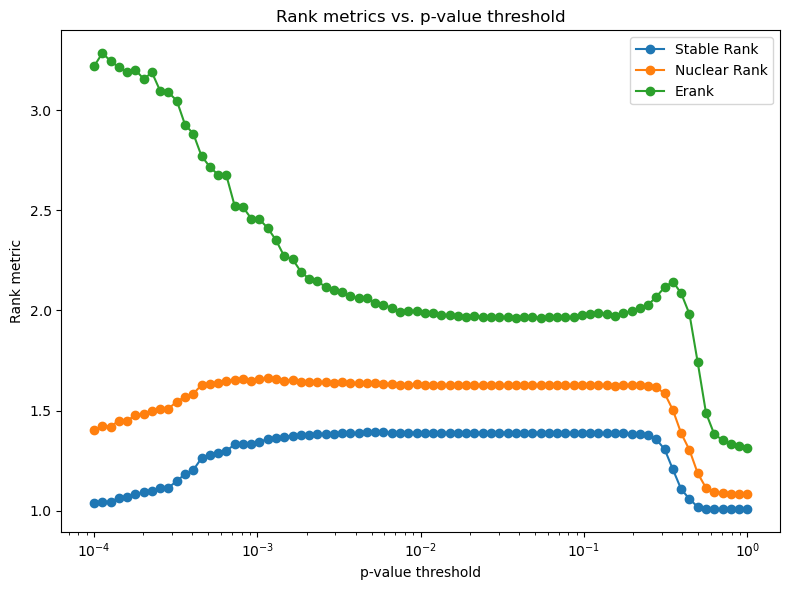

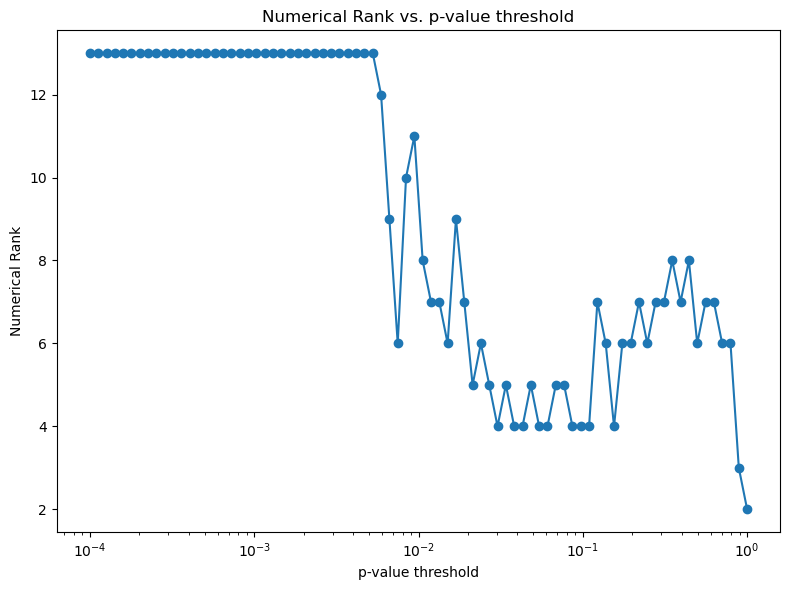

In [6]:
# === Define output directory ===
output_folder = Path("results/pvalue_threshold_analysis")
output_folder.mkdir(parents=True, exist_ok=True)

# === Prepare to record rank metrics ===
rank_records = []

# === Define p-value thresholds (log-spaced) ===
pvalue_thresholds = np.logspace(-4, 0, 80)  # from 1e-4 to 1

# === Main loop over thresholds ===
for p_thresh in pvalue_thresholds:
    print(p_thresh)

    # Transform log p-values to actual p-values
    df_valid = df.dropna(subset=['N: -Log ANOVA p value']).copy()
    df_valid['ANOVA p-value'] = 10 ** (-df_valid['N: -Log ANOVA p value'])
    filtered_genes = df_valid[df_valid['ANOVA p-value'] <= p_thresh]

    if len(filtered_genes) < 2:
        continue

    df_zscored = filtered_genes[selected_columns]

    # Normalize distances
    max_distance = get_max_distance_from_permutations(df_zscored, num_permutations=0)
    row_distance = pdist(df_zscored.values, metric='euclidean') / max_distance
    col_distance = pdist(df_zscored.T.values, metric='euclidean') / max_distance
    row_linkage = linkage(row_distance, method='average')
    col_linkage = linkage(col_distance, method='average')

    # Clustermap
    clustermap = sns.clustermap(df_zscored, row_cluster=True, col_cluster=True,
                                row_linkage=row_linkage, col_linkage=col_linkage,
                                metric='euclidean', cmap='coolwarm', figsize=(6, 12),
                                cbar_kws={'label': 'Z-score'})
    clustermap.fig.suptitle(f'Clustermap for p ≤ {p_thresh:.6f}')
    clustermap_path = output_folder / f'clustermap_p{p_thresh:.6f}.svg'

    # Label y-axis with gene names
    row_labels = list(filtered_genes['T: Genes'])
    reordered_row_labels = [row_labels[i] for i in clustermap.dendrogram_row.reordered_ind]
    clustermap.ax_heatmap.set_yticks(np.arange(len(reordered_row_labels)))
    clustermap.ax_heatmap.set_yticklabels(reordered_row_labels, fontsize=6, rotation=0)

    clustermap.savefig(clustermap_path)
    plt.close(clustermap.fig)

    # Consensus clustering
    num_bootstraps = 2000
    noise_level = 2.0
    n_cols = df_zscored.shape[1]
    consensus_matrix = np.zeros((n_cols, n_cols))
    for _ in range(num_bootstraps):
        df_bootstrap = df_zscored.sample(frac=1, replace=True, axis=0)
        df_noisy = add_white_noise(df_bootstrap, noise_level=noise_level)
        col_linkage = perform_clustering(df_noisy)
        clusters = fcluster(col_linkage, t=2, criterion='maxclust')
        for i in range(n_cols):
            for j in range(n_cols):
                if clusters[i] == clusters[j]:
                    consensus_matrix[i, j] += 1
    consensus_matrix /= num_bootstraps

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(consensus_matrix, ax=ax, cmap='coolwarm', xticklabels=selected_columns, yticklabels=selected_columns)
    ax.set_title(f'Consensus matrix (p ≤ {p_thresh:.6f})')
    consensus_path = output_folder / f'consensus_p{p_thresh:.6f}.svg'
    plt.savefig(consensus_path)
    plt.close(fig)

    # Compute rank metrics
    X = consensus_matrix
    singular_values = np.linalg.svd(X, compute_uv=False)
    stable_rank = np.sum(singular_values**2) / (singular_values[0]**2)
    nuclear_rank = np.sum(singular_values) / singular_values[0]
    prob = singular_values / np.sum(singular_values)
    prob = prob[prob > 1e-12]
    erank = np.exp(-np.sum(prob * np.log(prob)))
    numerical_rank = np.sum(singular_values > 1e-12)

    rank_records.append({
        'p-threshold': p_thresh,
        'Stable Rank': stable_rank,
        'Nuclear Rank': nuclear_rank,
        'Erank': erank,
        'Numerical Rank': numerical_rank,
        'Num Genes': len(filtered_genes)
    })

# === Save summary results ===
rank_df = pd.DataFrame(rank_records)
rank_df_path = output_folder / 'rank_summary.csv'
rank_df.to_csv(rank_df_path, index=False)

# === Plot rank metrics ===
plt.figure(figsize=(8, 6))
for col in ['Stable Rank', 'Nuclear Rank', 'Erank']:
    plt.plot(rank_df['p-threshold'], rank_df[col], marker='o', label=col)
plt.xscale('log')
plt.xlabel('p-value threshold')
plt.ylabel('Rank metric')
plt.title('Rank metrics vs. p-value threshold')
plt.legend()
plt.tight_layout()
plt.savefig(output_folder / 'rank_metrics_vs_p.svg')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(rank_df['p-threshold'], rank_df['Numerical Rank'], marker='o', label='Numerical Rank')
plt.xscale('log')
plt.xlabel('p-value threshold')
plt.ylabel('Numerical Rank')
plt.title('Numerical Rank vs. p-value threshold')
plt.tight_layout()
plt.savefig(output_folder / 'numerical_rank_vs_p.svg')
plt.show()
